Necessary imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

#loading Vgg16 CNN
model = torch.hub.load("pytorch/vision:v0.10.0", "vgg16", pretrained=False)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training and Testing data variables and Loaders

In [2]:
test_path = "/content/Testing"
train_path = "/content/Training"
batch_size = 64

preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAutocontrast(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.GTSRB(
    root="/content",
    split="train",
    download=True,
    transform=preprocess,
)

test_dataset = datasets.GTSRB(
    root="/content",
    split="test",
    download=True,
    transform=preprocess,
)

train_dataLoader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True, num_workers=2
)
print("Train", len(train_dataset))

test_dataLoader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=True, num_workers=2
)
print("Test", len(test_dataset))


  0%|          | 0/187490228 [00:00<?, ?it/s]

Extracting /content/gtsrb/GTSRB-Training_fixed.zip to /content/gtsrb


  0%|          | 0/88978620 [00:00<?, ?it/s]

Extracting /content/gtsrb/GTSRB_Final_Test_Images.zip to /content/gtsrb


  0%|          | 0/99620 [00:00<?, ?it/s]

Extracting /content/gtsrb/GTSRB_Final_Test_GT.zip to /content/gtsrb
Train 26640
Test 12630


Hyper Parameters

In [3]:
num_classes = 43
num_epochs = 20
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

Loass and optimizers

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5) 

Model Training using train_dataLoader

In [5]:
import time

start_time = time.time()
total_step = len(train_dataLoader)
accuracy_list = []

steps_list = []
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataLoader):
        images, labels = data[0].to(device), data[1].to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropogation and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)

        correct = (predicted == labels).sum().item()

        steps = i + 1
        if steps % 10 == 0:
            accuracy = (correct / total) * 100
            accuracy_list.append(accuracy)
            steps_list.append(steps)
            train_loss.append(loss.item())
            print(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%".format(
                    epoch + 1, num_epochs, steps, total_step, loss.item(), accuracy
                )
            )
        scheduler.step()

print(
    "######## Training Finished in {} seconds ###########".format(
        time.time() - start_time
    )
)
print("Accuracy List: ", accuracy_list, "Steps List: ", steps_list)


Epoch [1/20], Step [10/417], Loss: 5.1455, Accuracy: 6.25%
Epoch [1/20], Step [20/417], Loss: 4.0530, Accuracy: 4.69%
Epoch [1/20], Step [30/417], Loss: 3.6999, Accuracy: 6.25%
Epoch [1/20], Step [40/417], Loss: 3.7083, Accuracy: 6.25%
Epoch [1/20], Step [50/417], Loss: 3.4808, Accuracy: 9.38%
Epoch [1/20], Step [60/417], Loss: 3.6166, Accuracy: 9.38%
Epoch [1/20], Step [70/417], Loss: 3.6473, Accuracy: 6.25%
Epoch [1/20], Step [80/417], Loss: 3.5348, Accuracy: 4.69%
Epoch [1/20], Step [90/417], Loss: 3.3971, Accuracy: 14.06%
Epoch [1/20], Step [100/417], Loss: 3.6200, Accuracy: 3.12%
Epoch [1/20], Step [110/417], Loss: 3.4817, Accuracy: 3.12%
Epoch [1/20], Step [120/417], Loss: 3.4828, Accuracy: 9.38%
Epoch [1/20], Step [130/417], Loss: 3.4299, Accuracy: 6.25%
Epoch [1/20], Step [140/417], Loss: 3.2311, Accuracy: 7.81%
Epoch [1/20], Step [150/417], Loss: 3.5091, Accuracy: 14.06%
Epoch [1/20], Step [160/417], Loss: 3.2794, Accuracy: 6.25%
Epoch [1/20], Step [170/417], Loss: 2.9136, Acc

Plotting accuracy graph

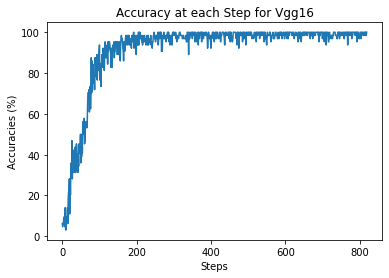

In [6]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Step for Vgg16")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(accuracy_list)

pyplot.show()

Plotting training loss graph

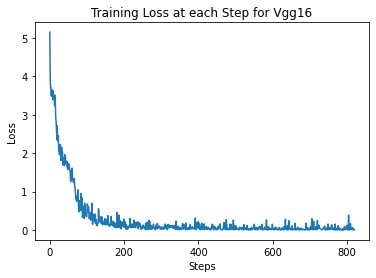

In [7]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Training Loss at each Step for Vgg16")
pyplot.xlabel("Steps")
pyplot.ylabel("Loss")
pyplot.plot(train_loss)

pyplot.show()

In [8]:
from torch.autograd import Variable
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
import torch.nn.functional as F

pred_y = []
lable_given_img = []

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)

        for i in pred :
          pred_y.append(i.abs().tolist())
        for i in target :
          lable_given_img.append(i.abs().tolist())

        correct += (pred == target).sum()
        
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

Testing accuracy corresponding to test_dataLoader

In [9]:
for epoch in range(num_epochs):
  evaluate(test_dataLoader)

<ipython-input-8-33b125f0acf2>:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Validation loss: 0.49319	Accuracy: 91.46476745605469 %

Average Validation loss: 0.44333	Accuracy: 91.81314086914062 %

Average Validation loss: 0.46903	Accuracy: 91.47268676757812 %

Average Validation loss: 0.46875	Accuracy: 91.71021270751953 %

Average Validation loss: 0.47337	Accuracy: 91.63103485107422 %

Average Validation loss: 0.46831	Accuracy: 91.42517852783203 %

Average Validation loss: 0.46467	Accuracy: 91.56769561767578 %

Average Validation loss: 0.46345	Accuracy: 91.61520385742188 %

Average Validation loss: 0.48040	Accuracy: 91.59144592285156 %

Average Validation loss: 0.46575	Accuracy: 91.57561492919922 %

Average Validation loss: 0.46410	Accuracy: 91.78939056396484 %

Average Validation loss: 0.46233	Accuracy: 91.51226806640625 %

Average Validation loss: 0.45974	Accuracy: 91.66270446777344 %

Average Validation loss: 0.46249	Accuracy: 91.74980163574219 %

Average Validation loss: 0.47459	Accuracy: 91.48851776123047 %

Average Validation loss: 0.48028	Accura

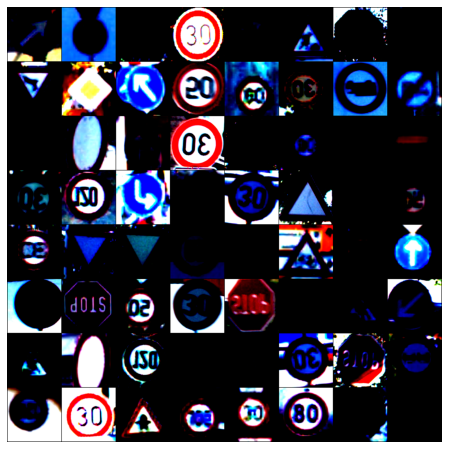

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in test_dataLoader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

Saving Model

In [11]:
PATH = '/content/Vgg_GTSRB.pt'
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'accuracy': accuracy_list
            }, PATH)

Printing Confusion Matrix

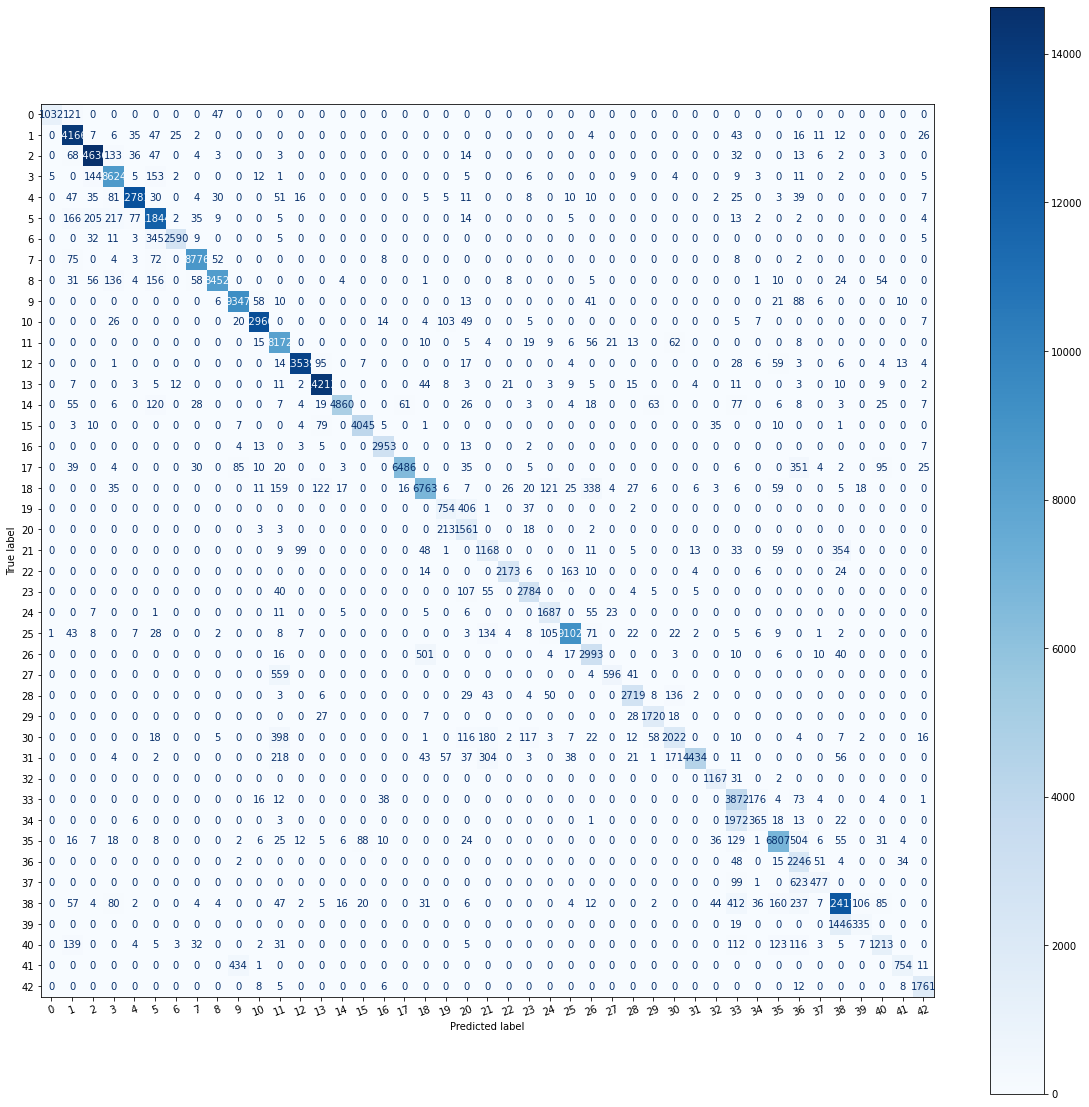

In [12]:
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

numClasses = 43
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, numClasses)
plot_confusion_matrix(lable_given_img, pred_y, labels_arr)

Prinitng Classification Report

In [13]:
from sklearn.metrics import classification_report
print(classification_report(lable_given_img, pred_y))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1200
           1       0.94      0.98      0.96     14400
           2       0.97      0.98      0.97     15000
           3       0.92      0.96      0.94      9000
           4       0.99      0.97      0.98     13200
           5       0.92      0.94      0.93     12600
           6       0.98      0.86      0.92      3000
           7       0.98      0.98      0.98      9000
           8       0.98      0.94      0.96      9000
           9       0.94      0.97      0.96      9600
          10       0.99      0.98      0.98     13200
          11       0.83      0.97      0.90      8400
          12       0.99      0.98      0.99     13800
          13       0.98      0.99      0.98     14400
          14       0.99      0.90      0.94      5400
          15       0.97      0.96      0.97      4200
          16       0.97      0.98      0.98      3000
          17       0.99    